# 05g needs to be update

Generate lists with overlapping genes for MPPs and HSCs and to assess specificity. Three levels of stringency 1.5 fold, 1.2 fold and all differentially expressed genes by MAST. 


done with this docker image:

docker run \
--rm \
-d \
--name scanpy2 \
-p 8880:8888 \
-e JUPYTER_ENABLE_LAB=YES \
-v /Users/efast/Documents/:/home/jovyan/work \
scanpy:1.4.6


In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import scipy.stats as stats
from helper_functions import *

from upsetplot import UpSet
import re
import scanpy as sc
%matplotlib inline


import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

## Read data

In [15]:
#make overlaps

treatments = ['dmPGE2', 'GCSF', 'indo', 'pIC']
cell_types = ['LT', 'MPP']

results_df=[]
results_df = pd.DataFrame(columns=['treatment', 'cell type', 'total female', 'total male', 'total_overlap',
                                                  'p-value', 'odds-ratio', 'prop unique female', 'prop unique female 1.2', 'prop unique female 1.5', 
                                                   'prop unique male', 'prop unique male 1.2', 'prop unique male 1.5', 
                                                    'overlap 1.2', 'overlap 1.5', 'male_up', 'female_up', 'opp_directionality'])
    
for treatment in treatments:
    for cell_type in cell_types:
        inpath_female = './write/MAST_' + treatment + '_' + cell_type + '_leiden_female.csv'
        inpath_male = './write/MAST_' + treatment + '_' + cell_type + '_leiden_male.csv'

        df_f = pd.read_csv(inpath_female)
        df_m = pd.read_csv(inpath_male)

        df_f = df_f.set_index('primerid')
        df_m = df_m.set_index('primerid')

        merge_df = pd.merge(df_f, df_m, left_index=True, right_index=True, how='inner', suffixes=('_female', '_male'))
        outer_df = pd.merge(df_f, df_m, left_index=True, right_index=True, how='outer', suffixes=('_female', '_male'))
        merge_df = merge_df[(pd.notna(merge_df["coef_female"])) & (pd.notna(merge_df["coef_male"]))]

        #measure things
        unique_f = len(outer_df[outer_df['coef_male'].isnull()])
        unique_m = len(outer_df[outer_df['coef_female'].isnull()])
        
        unique_f_12 = len(outer_df[(outer_df['coef_male'].isnull()) & (outer_df['coef_female'] > np.log(1.2))]) + len(outer_df[(outer_df['coef_female'].isnull()) & (outer_df['coef_female'] < np.log(10/12))])
        unique_f_15 = len(outer_df[(outer_df['coef_male'].isnull()) & (outer_df['coef_female'] > np.log(1.5))]) + len(outer_df[(outer_df['coef_female'].isnull()) & (outer_df['coef_male'] < np.log(10/15))])

        unique_m_12 = len(outer_df[(outer_df['coef_female'].isnull()) & (outer_df['coef_male'] > np.log(1.2))]) + len(outer_df[(outer_df['coef_female'].isnull()) & (outer_df['coef_male'] < np.log(10/12))])
        unique_m_15 = len(outer_df[(outer_df['coef_female'].isnull()) & (outer_df['coef_male'] > np.log(1.5))]) + len(outer_df[(outer_df['coef_female'].isnull()) & (outer_df['coef_male'] < np.log(10/15))])

        overlap_12 = len(merge_df[(merge_df['coef_male'] > np.log(1.2)) | (merge_df['coef_female'] > np.log(1.2)) | (merge_df['coef_male'] < np.log(10/12)) | (merge_df['coef_male'] < np.log(10/12))])
        overlap_15 = len(merge_df[(merge_df['coef_male'] > np.log(1.5)) | (merge_df['coef_female'] > np.log(1.5)) | (merge_df['coef_male'] < np.log(10/15)) | (merge_df['coef_male'] < np.log(10/15))])
        
        merge_df['ratio'] = merge_df["coef_male"] / merge_df["coef_female"]
        male_up = len(merge_df[merge_df['ratio']>2])/len(merge_df)
        opposite_dir = len(merge_df[merge_df['ratio']<0])/len(merge_df)
        female_up = (len(merge_df[merge_df['ratio']<0.5]) - len(merge_df[merge_df['ratio']<0]))/len(merge_df)
        
        #fisher exact test
        a = len(merge_df)
        b = len(df_m) - len(merge_df)
        c = len(df_f) - len(merge_df)
        d = 10000 - (b+c+a)

        oddsratio, pvalue = stats.fisher_exact([[a, b], [c, d]])
    
    
        results_df = results_df.append(pd.DataFrame([[treatment, cell_type, len(df_f), len(df_m), len(merge_df),
                                                      pvalue, oddsratio, unique_f/len(df_f), unique_f_12/len(df_f), unique_f_15/len(df_f), 
                                                      unique_m/len(df_m), unique_m_12/len(df_m), unique_m_15/len(df_m), 
                                                      overlap_12, overlap_15, male_up, female_up, opposite_dir
                                                      ]], 
                                                   columns=['treatment', 'cell type', 'total female', 'total male', 'total_overlap',
                                                  'p-value', 'odds-ratio', 'prop unique female', 'prop unique female 1.2', 'prop unique female 1.5', 
                                                   'prop unique male', 'prop unique male 1.2', 'prop unique male 1.5', 
                                                    'overlap 1.2', 'overlap 1.5', 'male_up', 'female_up', 'opp_directionality']))

In [16]:
results_df

,treatment,cell type,total female,total male,total_overlap,p-value,odds-ratio,prop unique female,prop unique female 1.2,prop unique female 1.5,prop unique male,prop unique male 1.2,prop unique male 1.5,overlap 1.2,overlap 1.5,male_up,female_up,opp_directionality
0,dmPGE2,LT,300,1369,207,1.969124e-111,16.354506,0.310000,0.053333,0.01,0.848795,0.204529,0.011687,169,67,0.019324,0.188406,0.004831
0,dmPGE2,MPP,1604,1033,764,0.000000e+00,27.478439,0.523691,0.011222,0.00,0.259439,0.008712,0.000000,262,44,0.009162,0.028796,0.001309
0,GCSF,LT,3574,2961,2222,0.000000e+00,12.647543,0.378288,0.000560,0.00,0.249578,0.002364,0.000338,264,14,0.079658,0.009901,0.007651
0,GCSF,MPP,2642,2120,1606,0.000000e+00,20.641092,0.392127,0.003028,0.00,0.242453,0.002830,0.000000,559,41,0.010585,0.011208,0.000623
0,indo,LT,471,423,156,4.286727e-104,17.179383,0.668790,0.004246,0.00,0.631206,0.000000,0.000000,16,1,0.012821,0.012821,0.153846
0,indo,MPP,24,15,6,4.790493e-13,369.148148,0.750000,0.125000,0.00,0.600000,0.133333,0.000000,0,0,0.000000,0.000000,0.000000
0,pIC,LT,1055,846,544,0.000000e+00,30.467412,0.484360,0.015166,0.00,0.356974,0.057920,0.001182,267,57,0.049632,0.023897,0.001838
0,pIC,MPP,616,601,282,7.536706e-200,23.992736,0.542208,0.011364,0.00,0.530782,0.044925,0.001664,130,47,0.014184,0.088652,0.010638


make graph and label genes that fall outside
calculate who many genes fall outside 1:1 range and percentage
for indo look at those genes


ratio up 


In [5]:
def plot_coef_label(treatment, celltype, bound):

    inpath_female = './write/MAST_' + treatment + '_' + cell_type + '_leiden_female.csv'
    inpath_male = './write/MAST_' + treatment + '_' + cell_type + '_leiden_male.csv'

    df_f = pd.read_csv(inpath_female)
    df_m = pd.read_csv(inpath_male)

    df_f = df_f.set_index('primerid')
    df_m = df_m.set_index('primerid')

    merge_df = pd.merge(df_f, df_m, left_index=True, right_index=True, how='inner', suffixes=('_female', '_male'))
    outer_df = pd.merge(df_f, df_m, left_index=True, right_index=True, how='outer', suffixes=('_female', '_male'))
    merge_df = merge_df[(pd.notna(merge_df["coef_female"])) & (pd.notna(merge_df["coef_male"]))]

    merge_df['ratio'] = merge_df["coef_male"] / merge_df["coef_female"]

    x = merge_df['coef_female']
    y = merge_df['coef_male']
    
    fig, ax = plt.subplots(figsize=(8,6))

    b = 2*x
    c = 0.5*x

    #ax = fig.add_subplot(1, 1, 1)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.plot(x, y, 'o', label="data")
    ax.plot(x, x, 'r', label="female = male")
    ax.plot(x, b, 'r:', label= 'threshold')
    ax.plot(x, c, 'r:')
    plt.xlim(-1*bound, bound)
    plt.ylim(-1*bound, bound)
    plt.xlabel('coef female', horizontalalignment='right', position=(1,25))
    plt.ylabel('coef male', horizontalalignment='right', position=(1,1))
    
    labels = df.index
    l = [i for i in df['ratio']] # this is subsets y to the ratio
    
    to_remove_1 = np.where([i > 0.5 for i in l])[0]
    to_remove_2 = np.where([i < 0.5 for i in y])[0]
    to_remove = np.union1d(to_remove_1, to_remove_2)
    #to_remove = np.where([(i > 0.5) | (y < 0.5) for i in l])[0] # this gets the indexes of entries that should be removed
    labels = ["" if i in to_remove else lab for i,lab in enumerate(labels) ] # which genes to label, labels is empty list except for genes that should be labled
    
    for i,txt in enumerate(labels):
        ax.annotate(txt, (x[i], y[i]))
 
    ax.legend(loc='best')
    plt.show()

In [11]:
def plot_coef(treatment, cell_type, bound):

    inpath_female = './write/MAST_' + treatment + '_' + cell_type + '_leiden_female.csv'
    inpath_male = './write/MAST_' + treatment + '_' + cell_type + '_leiden_male.csv'

    df_f = pd.read_csv(inpath_female)
    df_m = pd.read_csv(inpath_male)

    df_f = df_f.set_index('primerid')
    df_m = df_m.set_index('primerid')

    merge_df = pd.merge(df_f, df_m, left_index=True, right_index=True, how='inner', suffixes=('_female', '_male'))
    outer_df = pd.merge(df_f, df_m, left_index=True, right_index=True, how='outer', suffixes=('_female', '_male'))
    merge_df = merge_df[(pd.notna(merge_df["coef_female"])) & (pd.notna(merge_df["coef_male"]))]

    merge_df['ratio'] = merge_df["coef_male"] / merge_df["coef_female"]

    x = merge_df['coef_female']
    y = merge_df['coef_male']
    
    fig, ax = plt.subplots(figsize=(8,6))

    b = 2*x
    c = 0.5*x

    #ax = fig.add_subplot(1, 1, 1)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.plot(x, y, 'o', label="data")
    ax.plot(x, x, 'r', label="female = male")
    ax.plot(x, b, 'r:', label= 'threshold')
    ax.plot(x, c, 'r:')
    plt.xlim(-1*bound, bound)
    plt.ylim(-1*bound, bound)
    plt.xlabel('coef female', horizontalalignment='right', position=(1,25))
    plt.ylabel('coef male', horizontalalignment='right', position=(1,1))
 
    ax.legend(loc='best')
    path_out = './figures/' + treatment + '_' + cell_type + '_corrl_coef.pdf'
    
    plt.savefig(path_out, bbox_inches = "tight")
    plt.show()

### dmPGE2

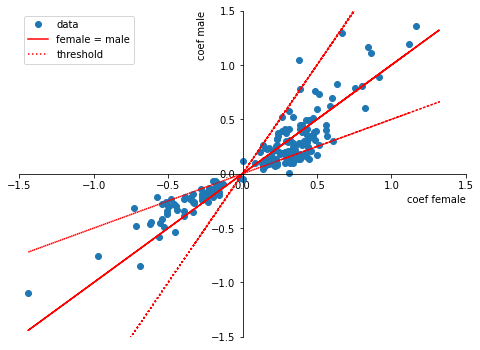

In [12]:
plot_coef('dmPGE2', 'LT', 1.5)

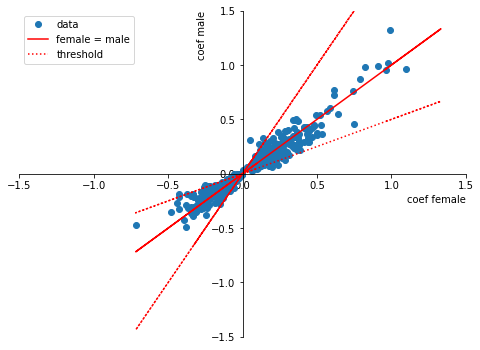

In [13]:
plot_coef('dmPGE2', 'MPP', 1.5)

### indo

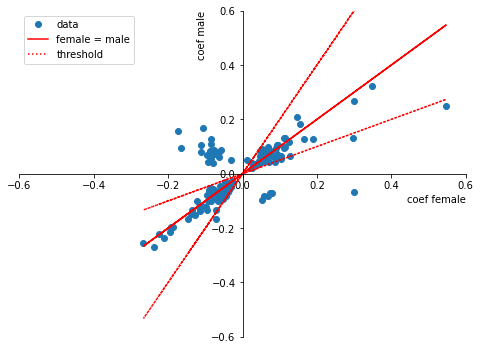

In [14]:
plot_coef('indo', 'LT', 0.6)

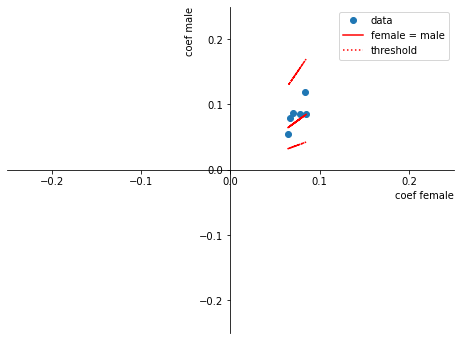

In [15]:
plot_coef('indo', 'MPP', 0.25)

### GCSF

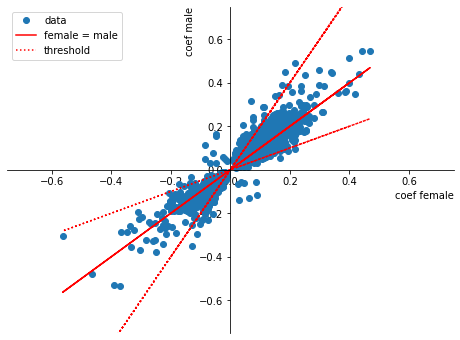

In [16]:
plot_coef('GCSF', 'LT', 0.75)

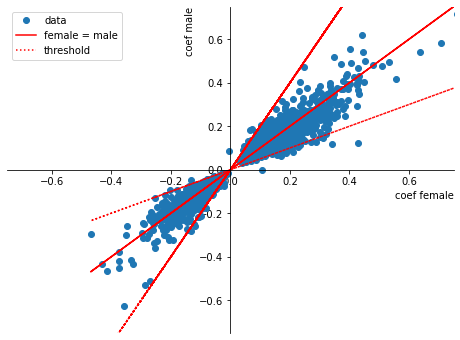

In [17]:
plot_coef('GCSF', 'MPP', 0.75)

### pIC

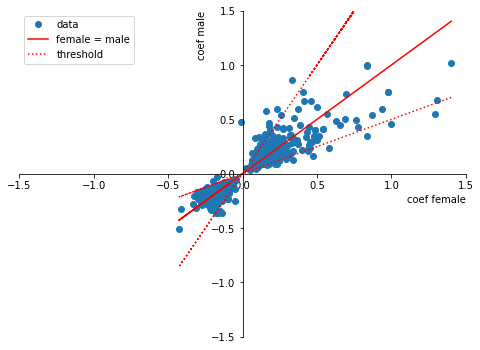

In [18]:
plot_coef('pIC', 'LT', 1.5)

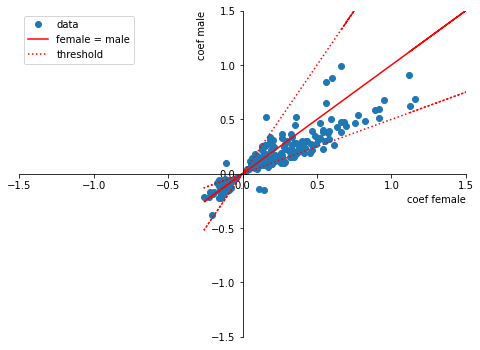

In [19]:
plot_coef('pIC', 'MPP', 1.5)

In [ ]:
!pip list